# CDFS&ndash;ELAIS-S1 Transfer

We want to know if a classifier trained on CDFS will work on ELAIS-S1. There's a few questions that need to be resolved:

- Will the CDFS-trained feature extractor act the same on the ELAIS-S1 field?
- Will a classifier trained on extracted CDFS features work on extracted ELAIS-S1 features?
- Does a classifier that just uses non-CNN features work as well on ELAIS-S1 as on CDFS?

In [4]:
import re

from astropy.coordinates import SkyCoord
import astropy.io
import astropy.visualization
import astropy.visualization.mpl_normalize
import crowdastro.crowd.util
import h5py
import keras.models
import matplotlib.pyplot as plt
import numpy
import seaborn
import sklearn.linear_model
import sklearn.neighbors

%matplotlib inline

Using Theano backend.


In [5]:
CROWDASTRO_PATH = '../data/crowdastro_wise_elais.h5'
CDFS_TRAINING_PATH = '../data/training.h5'
ELAIS_TRAINING_PATH = '../data/training_elais.h5'
CNN_WEIGHTS_PATH = '../data/weights.h5'
CNN_MODEL_PATH = '../data/model.json'
MIDDELBERG_PATH = '../data/middelberg_2008_atlas_classifications.dat'
ELAIS_IMAGE_PATH = '../data/ELAISmosaic_allch_8March2015.fits'
CDFS_IMAGE_PATH = '../data/CDFSmosaic_allch_8March2015.fits'
IMAGE_WIDTH = IMAGE_HEIGHT = 32
IMAGE_SIZE = IMAGE_WIDTH * IMAGE_HEIGHT
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT)

## CDFS-CNN Feature Distribution on CDFS and ELAIS-S1

We will henceforth refer to the convolutional neural network (CNN) feature extractor trained on the Radio Galaxy Zoo CDFS labels as the CDFS-CNN. In this section, we will investigate the distribution of features of the CDFS images and the ELAIS-S1 images.

First, let's make a set of CDFS and ELAIS-S1 image patches and load up the CDFS-CNN.

In [6]:
with open(CNN_MODEL_PATH, 'r') as model_f:
    cnn = keras.models.model_from_json(model_f.read())
cnn.load_weights(CNN_WEIGHTS_PATH)
get_convolutional_features_ = keras.backend.function(
        [cnn.layers[0].input], [cnn.layers[7].output])
get_convolutional_features = (lambda p:
        get_convolutional_features_([p])[0].reshape((p.shape[0], -1)))

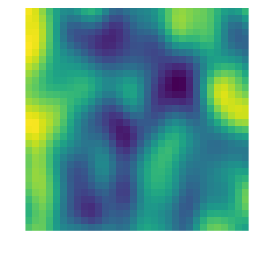

In [7]:
with h5py.File(CROWDASTRO_PATH, 'r') as crowdastro_h5:
    cdfs_images = crowdastro_h5['/wise/cdfs/numeric'][:, -IMAGE_SIZE:].reshape((-1, 1) + IMAGE_SHAPE)
    elais_images = crowdastro_h5['/wise/elais/numeric'][:, -IMAGE_SIZE:].reshape((-1, 1) + IMAGE_SHAPE)
    plt.imshow(elais_images[0, 0], interpolation='None', cmap='viridis')
    plt.axis('off')

Let's run these through the CDFS-CNN to get the feature representations of the objects in each field.

In [8]:
cdfs_features = get_convolutional_features(cdfs_images)

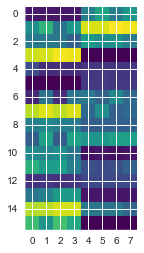

In [9]:
plt.imshow(cdfs_features.mean(axis=0).reshape((16, 8)), interpolation='None', cmap='viridis')

In [10]:
elais_features = get_convolutional_features(elais_images)

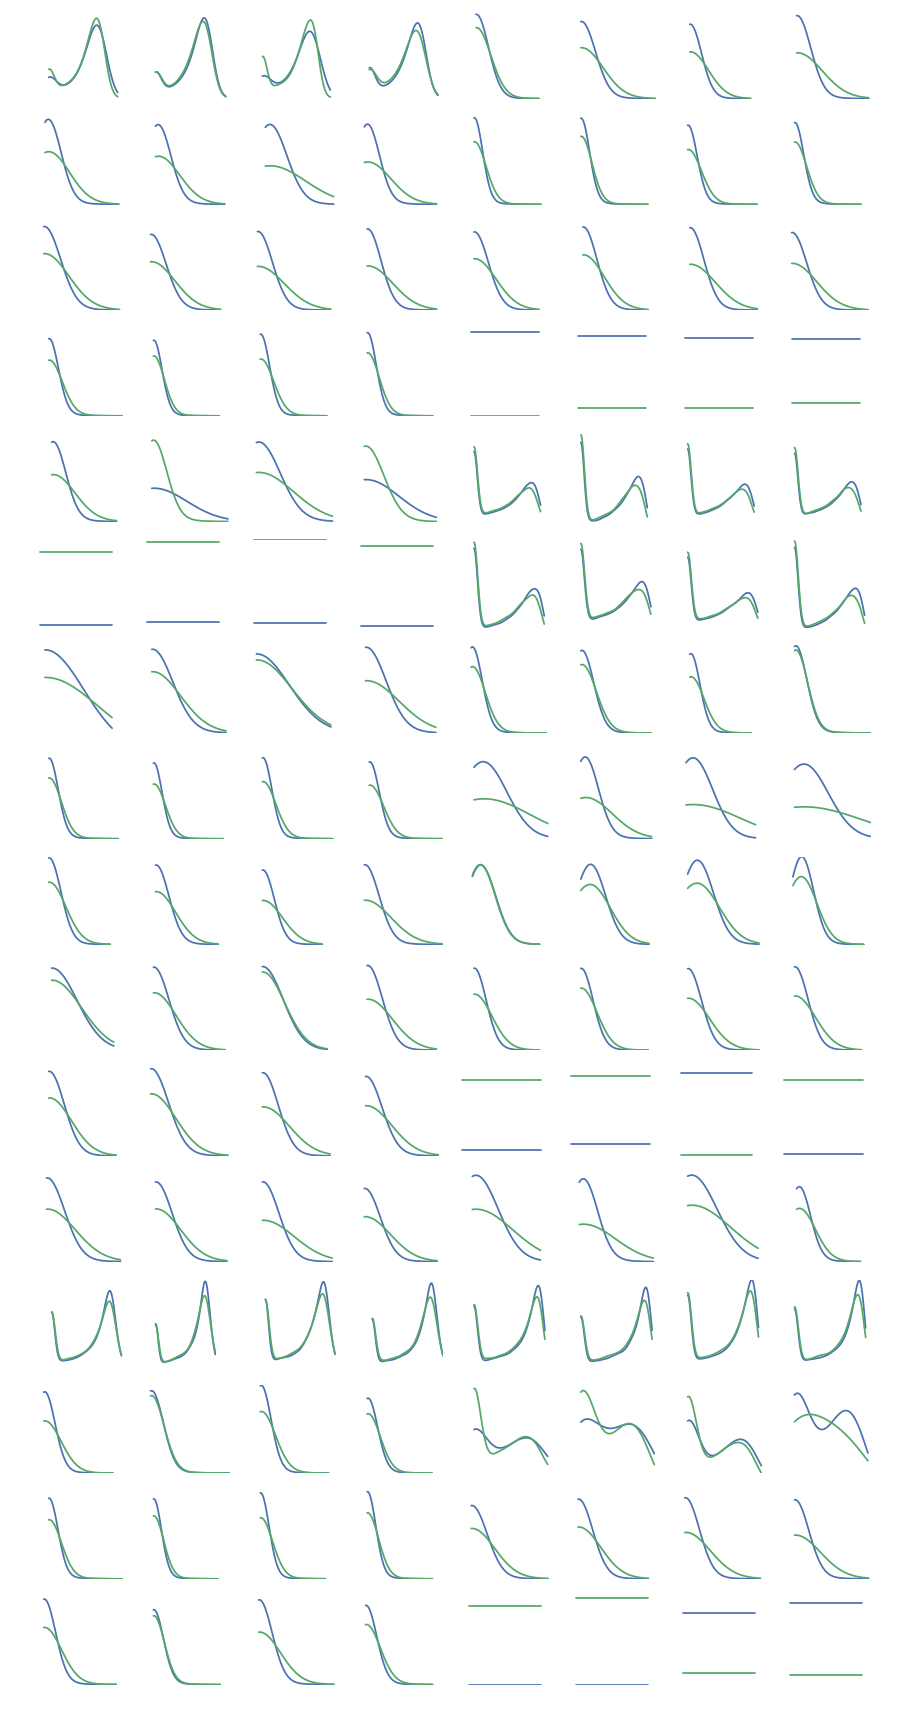

In [11]:
fig = plt.figure(figsize=(15, 30))
ax = fig.gca()
for feature in range(128):
    sub_ax = plt.subplot(16, 8, feature + 1)
    pc = numpy.percentile(cdfs_features[:, feature], (0.005, 99))
    seaborn.kdeplot(cdfs_features[:, feature], clip=pc, label='CDFS', legend=False)
    seaborn.kdeplot(elais_features[:, feature], clip=pc, label='ELAIS-S1', legend=False)
    plt.axis('off')
plt.show()

These look pretty different. Let's zoom in on feature 111, which seems particularly different.

(-0.15000000000000002, 0.29999999999999999, 0.0, 9.0)

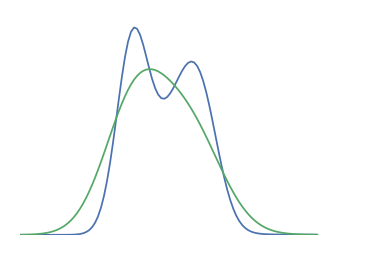

In [12]:
pc = (-0.15, 0.25)
seaborn.kdeplot(cdfs_features[:, 111], clip=pc, label='CDFS', legend=False)
seaborn.kdeplot(elais_features[:, 111], clip=pc, label='ELAIS-S1', legend=False)
plt.axis('off')

## The CDFS Classifier with CDFS-CNN Features

Let's train a classifier on CDFS and run it on ELAIS-S1, then look at some predictions. Let's also just use the CDFS-CNN features &mdash; we can look at the WISE features separately.

In [13]:
with h5py.File(CDFS_TRAINING_PATH, 'r') as training_h5:
    features = cdfs_features
    labels = training_h5['labels'].value
    lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
    lr.fit(features, labels)

In [14]:
# Of course, to get proper CDFS predictions, we should use k-fold cross-validation.
cdfs_predictions = lr.predict(cdfs_features)
cdfs_probs = lr.predict(cdfs_features)
elais_predictions = lr.predict(elais_features)
elais_probs = lr.predict(elais_features)

In [15]:
# Quick sanity check.
crowdastro.crowd.util.balanced_accuracy(labels, cdfs_predictions)

0.84551208768255548

Let's compare this to the Middelberg labels. We first need to load those in.

In [16]:
# Load the coordinates of all infrared objects and initialise the labels array.
with h5py.File(CROWDASTRO_PATH, 'r') as crowdastro_h5:
    elais_coords = crowdastro_h5['/wise/elais/numeric'][:, :2]
    middelberg_labels = numpy.zeros((elais_coords.shape[0]))
    elais_kdtree = sklearn.neighbors.KDTree(elais_coords)

In [17]:
# Load the RA/Dec of the Middelberg objects.
ras = []
decs = []
for row in astropy.io.ascii.read(MIDDELBERG_PATH, header_start=0, delimiter='|'):
    swire = row['swire_name']
    if not swire:
        continue
    
    m = re.match('SWIRE J(\d{2})(\d{2})(\d{2}.\d{2})(-\d{2})(\d{2})(\d{2}.\d)', swire)
    rh, rm, rs, dd, dm, ds = [float(i) for i in m.groups()]
    coord = SkyCoord(ra=(rh, rm, rs), dec=(dd, dm, ds), unit=('hour', 'deg'))
    ra, dec = coord.ra.deg, coord.dec.deg
    ras.append(ra)
    decs.append(dec)
middelberg_coords = list(zip(*[ras, decs]))

In [18]:
# Find the nearest infrared object to each Middelberg object.
nearests = elais_kdtree.query(middelberg_coords, return_distance=False)

In [19]:
# Label the Middelberg objects as 1.
middelberg_labels[sorted(list(nearests.T[0]))] = 1

Now that the labels are loaded, we can compare our predictions.

In [20]:
crowdastro.crowd.util.balanced_accuracy(middelberg_labels, elais_predictions)

0.83639235677429191

We obtain similar balanced accuracy to CDFS.

## Visualising the Predictions

Let's plot the predictions onto an image of CDFS and ELAIS-S1.

In [21]:
# Get the RA/Dec of the CDFS predictions.
predicted_positive_cdfs = cdfs_predictions > 0.75

with h5py.File(CROWDASTRO_PATH, 'r') as crowdastro_h5:
    cdfs_coords = crowdastro_h5['/wise/cdfs/numeric'][:, :2]
    positive_cdfs_coords = cdfs_coords[predicted_positive_cdfs]
    positive_norris_coords = cdfs_coords[labels]

k:\languages\python35_64\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '


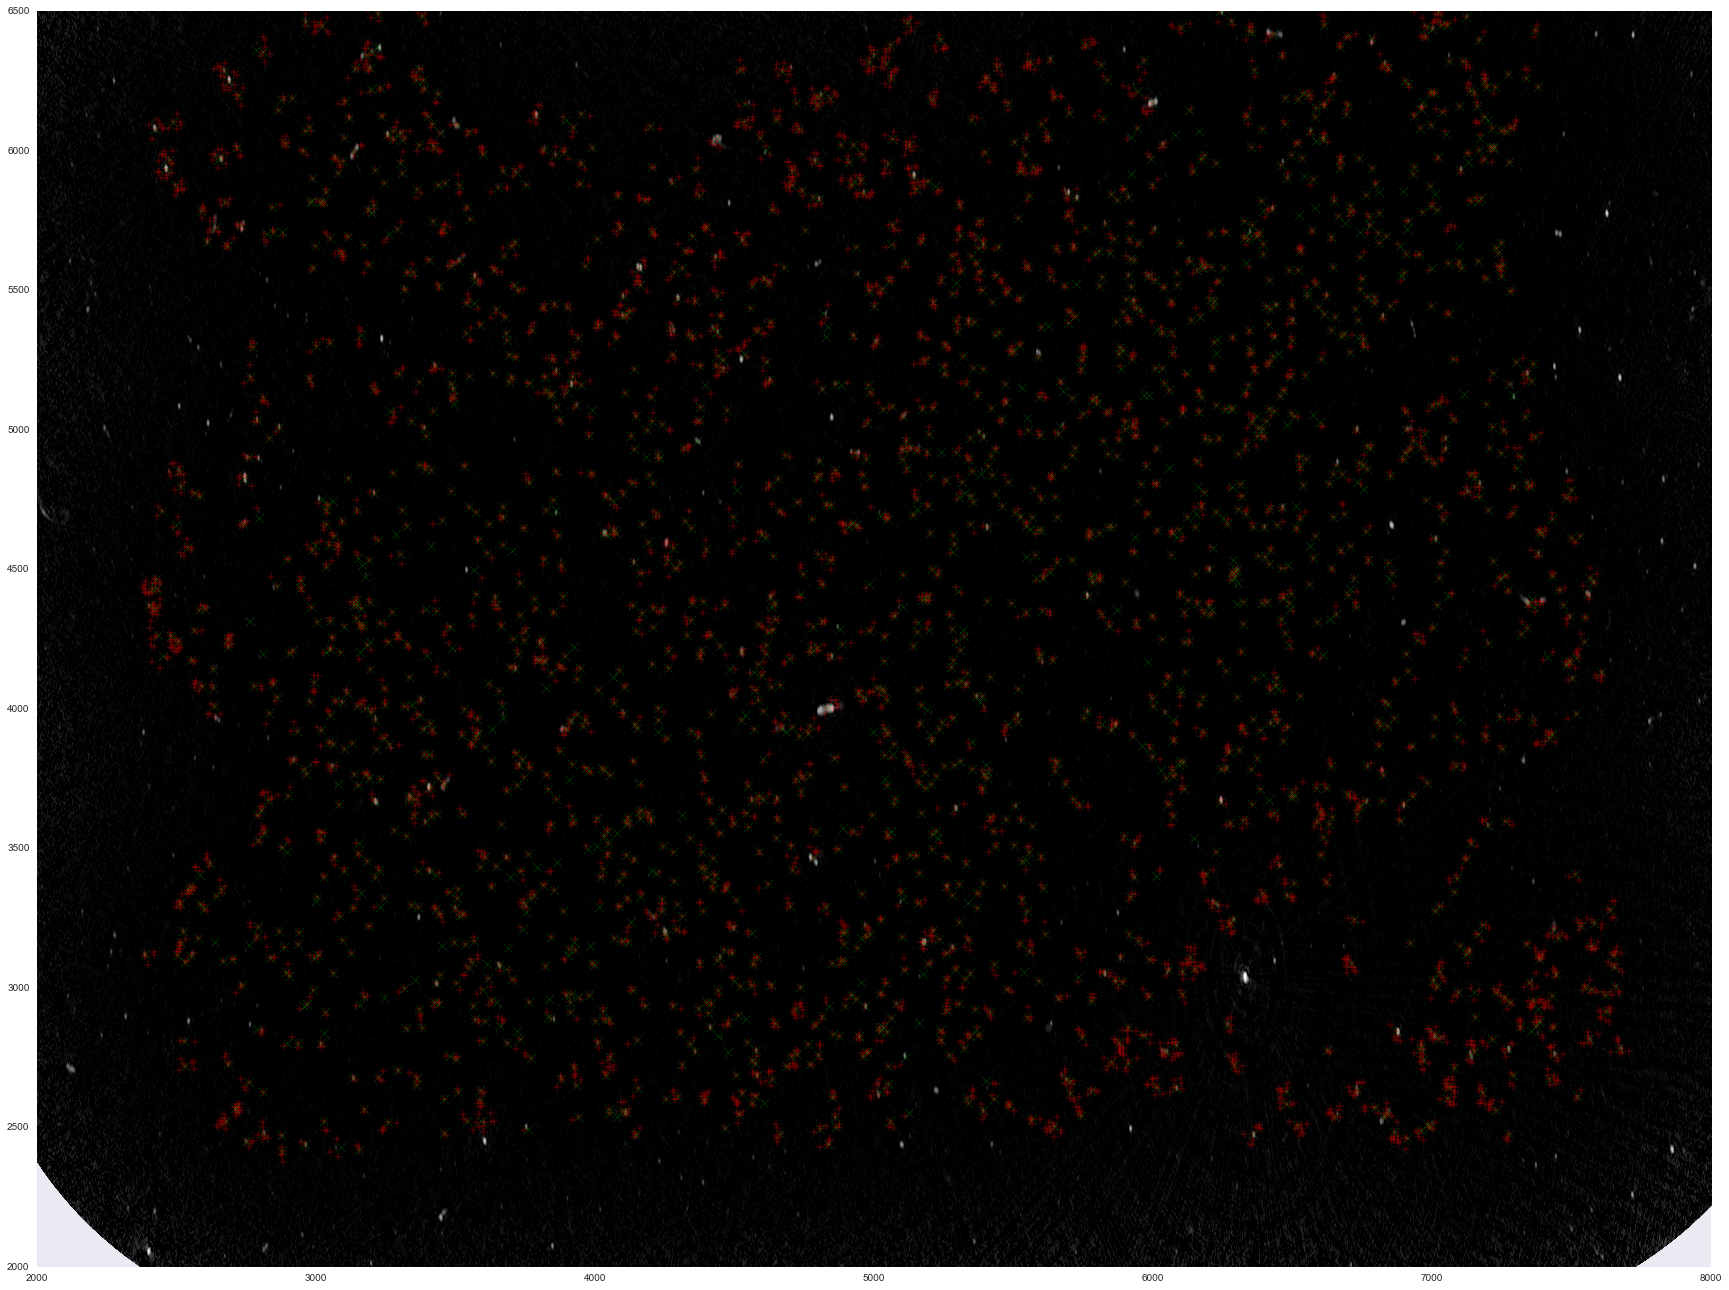

In [22]:
with astropy.io.fits.open(CDFS_IMAGE_PATH, ignore_blank=True) as cdfs_fits:
    # Plot the image.
    plt.figure(figsize=(30, 30))
    cdfs_image = cdfs_fits[0].data[0, 0]
    norm = astropy.visualization.mpl_normalize.ImageNormalize(
        vmin=0.0, vmax=0.25, stretch=astropy.visualization.LogStretch())
    plt.imshow(cdfs_image, cmap='gray', norm=norm, origin='lower left')
    plt.xlim((2000, 8000))
    plt.ylim((2000, 6500))
    plt.grid('off')
    # Plot the predictions. First we convert them into pixels...
    wcs = astropy.wcs.WCS(cdfs_fits[0].header).dropaxis(3).dropaxis(2)
    cdfs_predictions_px = wcs.all_world2pix(positive_cdfs_coords, 1)
    norris_predictions_px = wcs.all_world2pix(positive_norris_coords, 1)
    plt.scatter(cdfs_predictions_px[:, 0], cdfs_predictions_px[:, 1], s=80, color='red', marker='+')
    plt.scatter(norris_predictions_px[:, 0], norris_predictions_px[:, 1], s=80, color='green', marker='x')
    plt.show()

In [23]:
# Get the RA/Dec of the ELAIS predictions.
predicted_positive_elais = elais_predictions > 0.75

with h5py.File(CROWDASTRO_PATH, 'r') as crowdastro_h5:
    elais_coords = crowdastro_h5['/wise/elais/numeric'][:, :2]
    positive_elais_coords = elais_coords[predicted_positive_elais]
    positive_middelberg_coords = elais_coords[middelberg_labels.astype(bool)]

k:\languages\python35_64\lib\site-packages\astropy\io\fits\util.py:578: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '


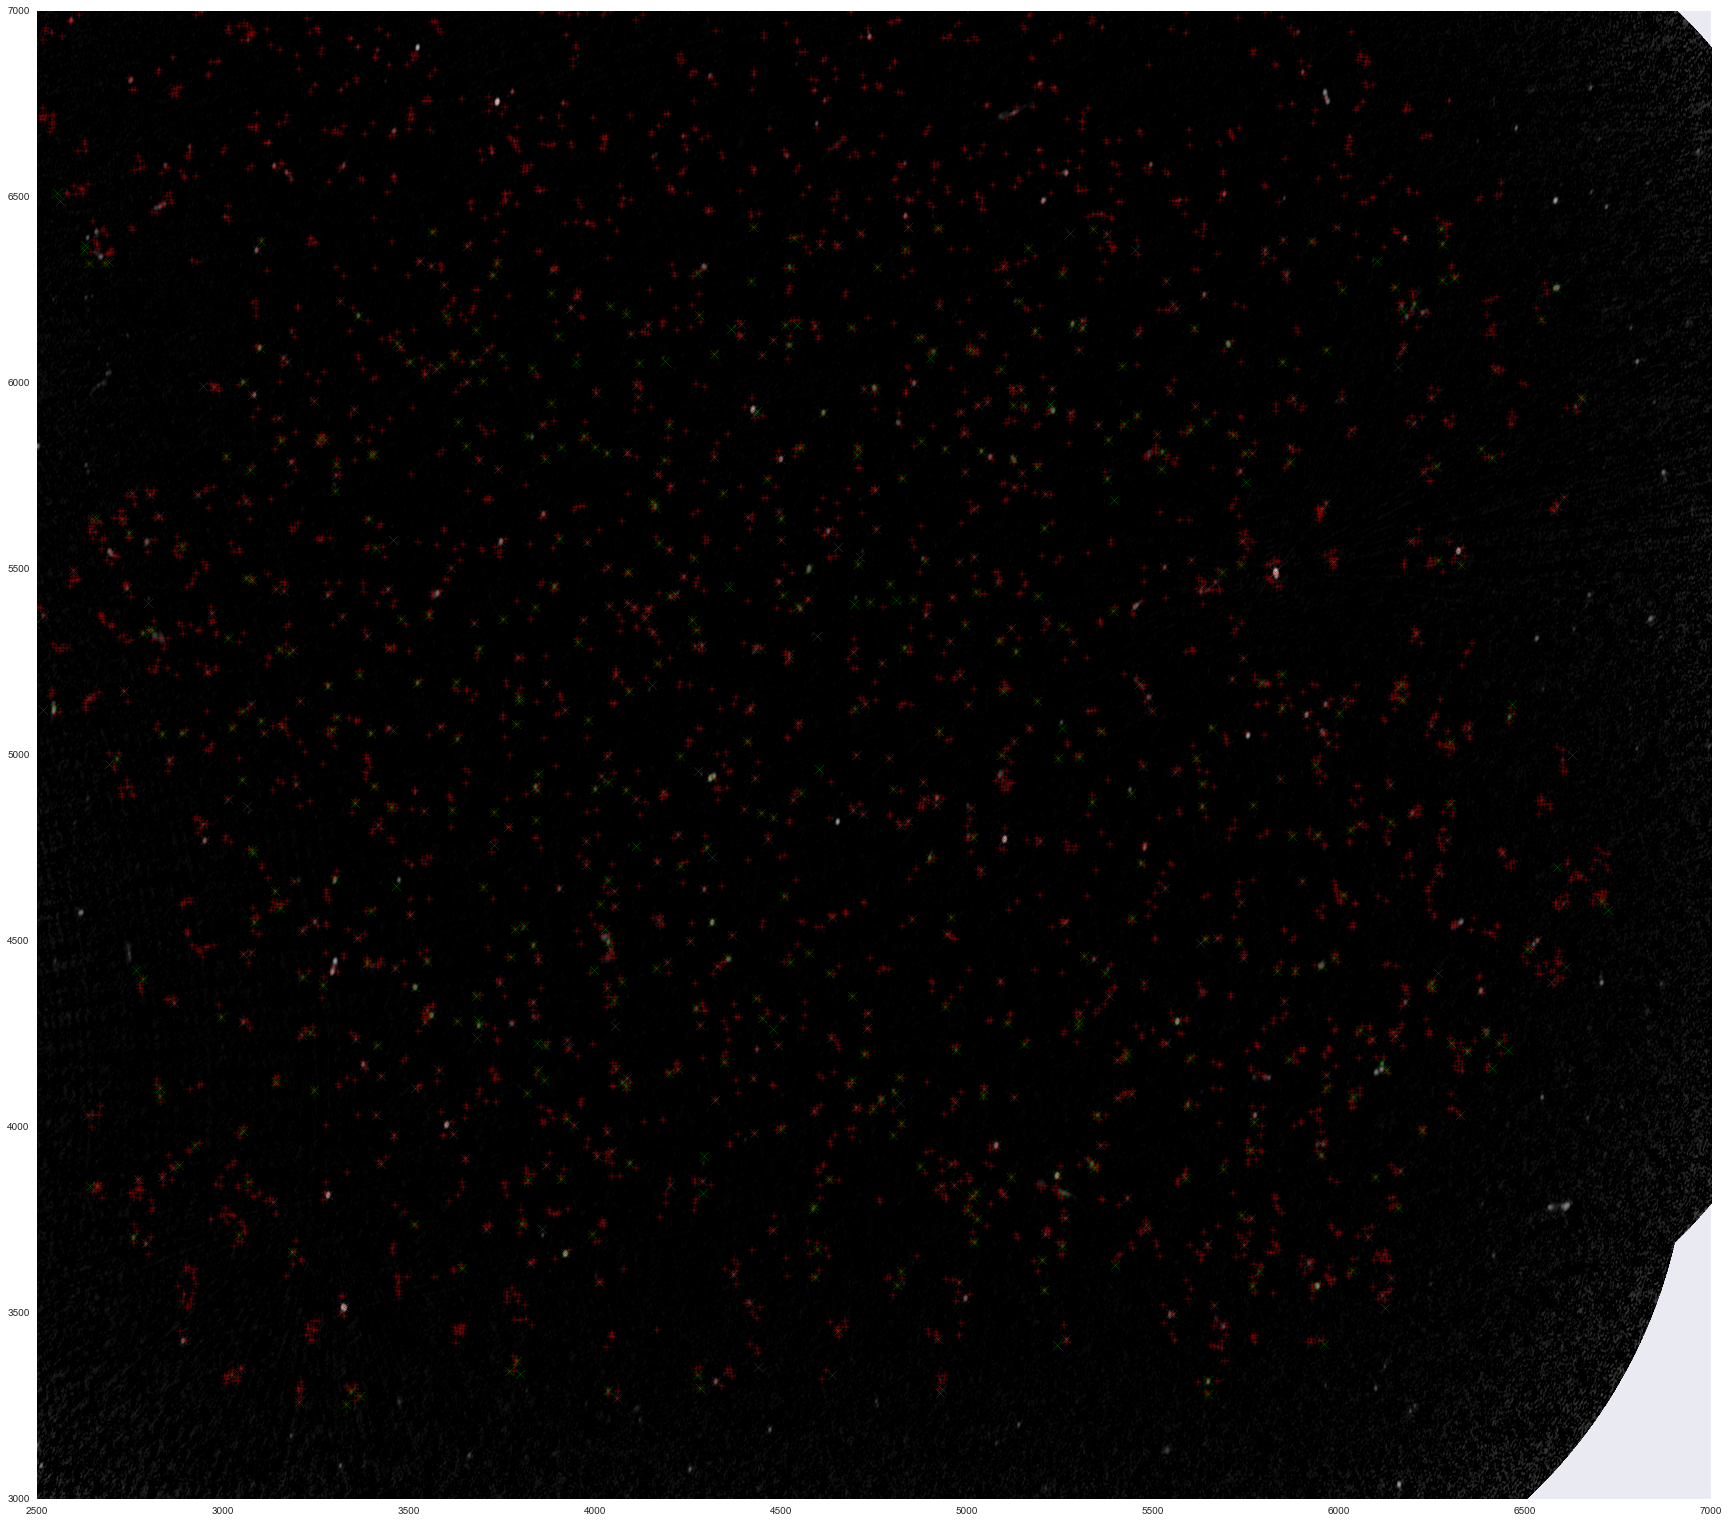

In [24]:
with astropy.io.fits.open(ELAIS_IMAGE_PATH, ignore_blank=True) as elais_fits:
    # Plot the image.
    plt.figure(figsize=(30, 30))
    elais_image = elais_fits[0].data[0, 0]
    norm = astropy.visualization.mpl_normalize.ImageNormalize(
        vmin=0.0, vmax=0.25, stretch=astropy.visualization.LogStretch())
    plt.imshow(elais_image, cmap='gray', norm=norm, origin='lower left')
    plt.xlim((2500, 7000))
    plt.ylim((3000, 7000))
    plt.grid('off')
    # Plot the predictions. First we convert them into pixels...
    wcs = astropy.wcs.WCS(elais_fits[0].header).dropaxis(3).dropaxis(2)
    elais_predictions_px = wcs.all_world2pix(positive_elais_coords, 1)
    middelberg_predictions_px = wcs.all_world2pix(positive_middelberg_coords, 1)
    plt.scatter(elais_predictions_px[:, 0], elais_predictions_px[:, 1], s=80, color='red', marker='+')
    plt.scatter(middelberg_predictions_px[:, 0], middelberg_predictions_px[:, 1], s=80, color='green', marker='x')
    plt.show()

## Applying the CDFS classifier to ELAIS-S1 without CNN features

In this section we will train a classifier on CDFS and apply it to ELAIS-S1, without using features extracted from the images. That means we will just use the infrared magnitudes and the distance feature.

In [31]:
# Train the classifier on CDFS.
with h5py.File(CDFS_TRAINING_PATH, 'r') as training_h5:
    features = training_h5['features'][:, :7]  # There are 7 non-CNN features for WISE.
    labels = training_h5['labels'].value
    
    train_features, test_features, train_labels, test_labels = sklearn.cross_validation.train_test_split(
        features, labels, train_size=0.8)
    lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
    lr.fit(train_features, train_labels)

In [33]:
# Test it on CDFS.
print(crowdastro.crowd.util.balanced_accuracy(test_labels, lr.predict(test_features)))

0.780276875425


In [34]:
# Test it on ELAIS-S1.
with h5py.File(ELAIS_TRAINING_PATH, 'r') as training_h5:
    print(crowdastro.crowd.util.balanced_accuracy(middelberg_labels, lr.predict(training_h5['features'][:, :7])))

0.754832024988
